Training Discrete Map Network...
Epoch 0, Loss: 0.386623
Epoch 200, Loss: 0.000119
Epoch 400, Loss: 0.000043
Epoch 600, Loss: 0.000023
Epoch 800, Loss: 0.000012


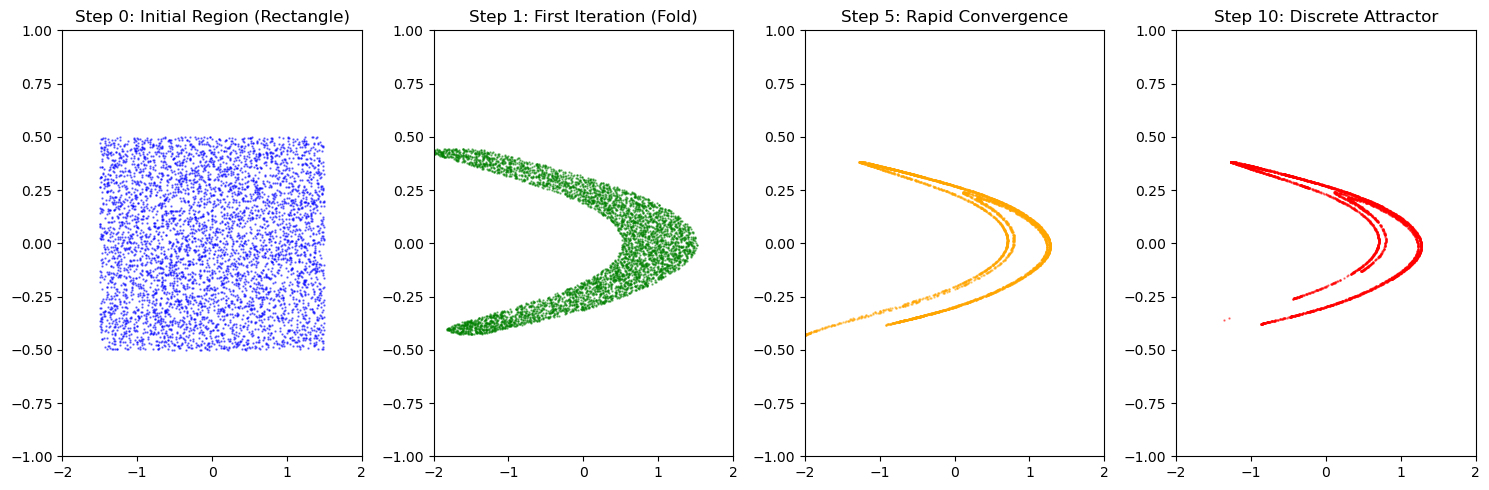

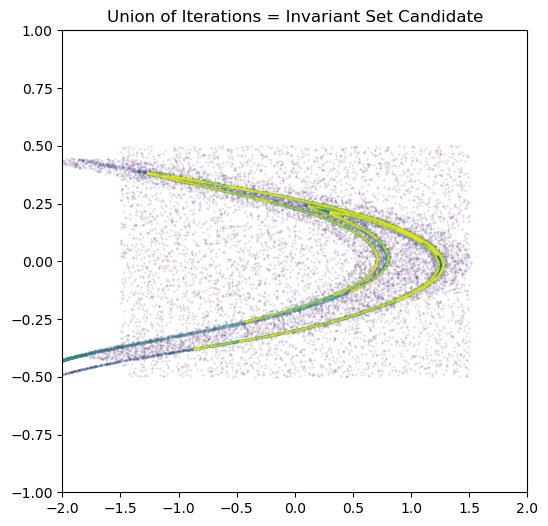

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Ground Truth: Hénon Map (Discrete Diffeomorphism)
def henon_map(xy, a=1.4, b=0.3):
    x, y = xy[:, 0], xy[:, 1]
    x_next = 1 - a * x**2 + y
    y_next = b * x
    return np.stack([x_next, y_next], axis=1).astype(np.float32)

# Generate Training Data
def generate_henon_data(steps=10000):
    # Start from a point usually on the attractor
    traj = [np.array([0.0, 0.0])]
    # Discard transient
    for _ in range(100):
        traj[0] = henon_map(np.array([traj[0]]))[0]
    
    for _ in range(steps):
        traj.append(henon_map(np.array([traj[-1]]))[0])
    return np.vstack(traj).astype(np.float32)

# 2. Neural Network (Pure Discrete Map Estimator)
class DiscreteMapNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple MLP to approximate the map
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(), # Smooth activation
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2) 
            # Note: No residual connection. Directly mapping x_n to x_{n+1}
        )
    
    def forward(self, x):
        return self.net(x)

# 3. Train
data = generate_henon_data(steps=5000)
X_train = torch.from_numpy(data[:-1])
Y_train = torch.from_numpy(data[1:])

model = DiscreteMapNet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

print("Training Discrete Map Network...")
for epoch in range(1000):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# 4. Visualization: The "Trapping Region" Concept
# 초기 분포를 Attractor보다 훨씬 큰 사각형으로 잡습니다.
# 이 사각형이 Hénon Map에 의해 어떻게 접히고 찌그러져서 
# Compact Invariant Set 안으로 들어가는지 봅니다.

n_samples = 5000
# Define a region roughly [-1.5, 1.5] x [-0.5, 0.5] (Trapping Region Candidate)
initial_state = (torch.rand(n_samples, 2) - 0.5) * 3.0 
initial_state[:, 1] = (torch.rand(n_samples) - 0.5) * 1.0

states = [initial_state]
current_state = initial_state

with torch.no_grad():
    for _ in range(10): # Discrete steps
        current_state = model(current_state)
        states.append(current_state)

# Plotting
plt.figure(figsize=(15, 5))

# t=0: Initial Rectangular Distribution
plt.subplot(1, 4, 1)
s = states[0].numpy()
plt.scatter(s[:,0], s[:,1], s=0.5, c='blue', alpha=0.5)
plt.title("Step 0: Initial Region (Rectangle)")
plt.xlim(-2, 2); plt.ylim(-1, 1)

# t=1: First folding (The Horseshoe shape appearing)
plt.subplot(1, 4, 2)
s = states[1].numpy()
plt.scatter(s[:,0], s[:,1], s=0.5, c='green', alpha=0.5)
plt.title("Step 1: First Iteration (Fold)")
plt.xlim(-2, 2); plt.ylim(-1, 1)

# t=5: Squashed onto the Attractor
plt.subplot(1, 4, 3)
s = states[5].numpy()
plt.scatter(s[:,0], s[:,1], s=0.5, c='orange', alpha=0.5)
plt.title("Step 5: Rapid Convergence")
plt.xlim(-2, 2); plt.ylim(-1, 1)

# t=10: The Strange Attractor
plt.subplot(1, 4, 4)
s = states[-1].numpy()
plt.scatter(s[:,0], s[:,1], s=0.5, c='red', alpha=0.5)
plt.title("Step 10: Discrete Attractor")
plt.xlim(-2, 2); plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

# Visualize the Invariant Set (Union)
plt.figure(figsize=(6, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(states)))
for i, state in enumerate(states):
    s = state.numpy()
    plt.scatter(s[:,0], s[:,1], s=0.1, color=colors[i], alpha=0.3)
plt.title("Union of Iterations = Invariant Set Candidate")
plt.xlim(-2, 2); plt.ylim(-1, 1)
plt.show()

Training General NN on Hénon...


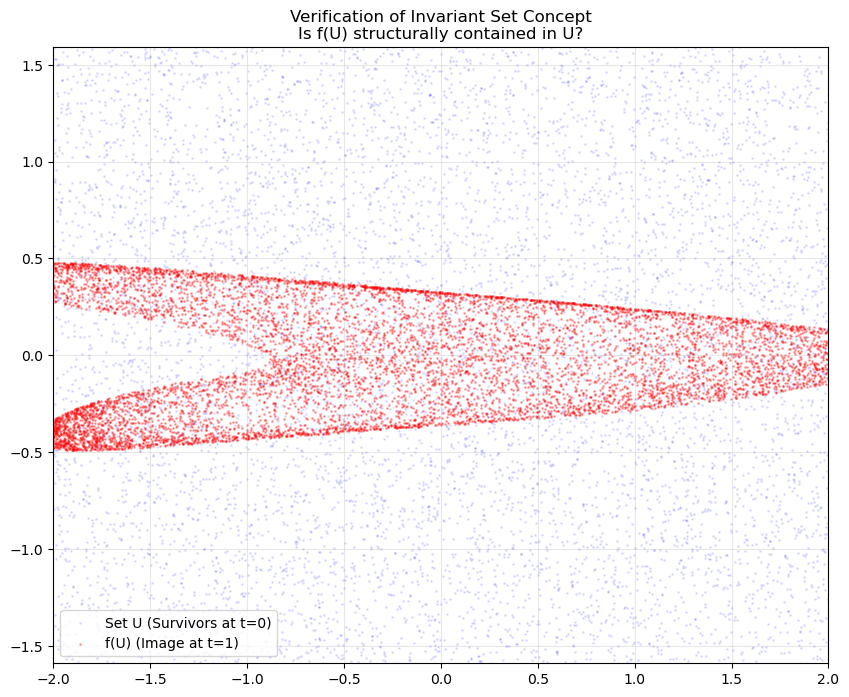

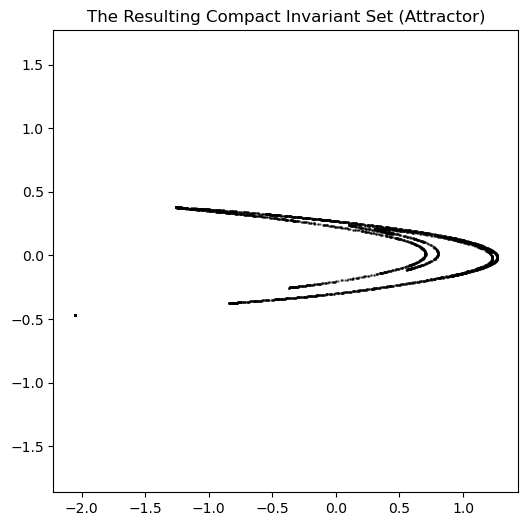

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Target: Hénon Map (Unbounded System)
def henon_map(xy, a=1.4, b=0.3):
    x, y = xy[:, 0], xy[:, 1]
    x_next = 1 - a * x**2 + y
    y_next = b * x
    return np.stack([x_next, y_next], axis=1).astype(np.float32)

def generate_henon_data(steps=5000):
    # Attractor 근처에서 데이터 생성
    traj = [np.array([0.0, 0.0])]
    for _ in range(100): # Transient 제거
        traj[0] = henon_map(np.array([traj[0]]))[0]
    for _ in range(steps):
        traj.append(henon_map(np.array([traj[-1]]))[0])
    return np.vstack(traj).astype(np.float32)

# 2. General Neural Network (No artificial Tanh bound)
# 일반적인 ReLU/Linear 조합 등을 써도 되지만, 
# Chaos 학습에는 Smooth한 Tanh가 유리하므로 Activation만 Tanh 사용.
# Output은 제한 없음 (Linear).
class GeneralHenonNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2) # <--- Output Unbounded (Linear)
        )
    
    def forward(self, x):
        return self.net(x)

# 3. Train
data = generate_henon_data(steps=5000)
X_train = torch.from_numpy(data[:-1])
Y_train = torch.from_numpy(data[1:])

model = GeneralHenonNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Quick Training
print("Training General NN on Hénon...")
for epoch in range(1000):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

# 4. Verification: Finding the Compact Invariant Set
# 개념 검증: "우리가 설정한 영역이 Invariant한가?"

# Step A: Define a broad region of interest
# Hénon Attractor는 대략 x:[-1.5, 1.5], y:[-0.4, 0.4] 에 있습니다.
# 이보다 조금 더 큰 영역에서 시작해봅니다.
n_samples = 10000
initial_state = (torch.rand(n_samples, 2) - 0.5) * 4.0 # [-2, 2] x [-2, 2]

# Step B: Filter diverging points (Basin of Attraction 찾기)
# NN을 50번 정도 태워서, 값이 너무 커지는(발산하는) 점들은 버립니다.
valid_indices = torch.arange(n_samples)
temp_state = initial_state.clone()

with torch.no_grad():
    for _ in range(50):
        temp_state = model(temp_state)
        # Hénon system에서 4.0 넘어가면 보통 발산함
        mask = temp_state.abs().max(dim=1).values < 5.0 
        temp_state = temp_state[mask]
        valid_indices = valid_indices[mask] # 살아남은 인덱스 추적

# 이제 '살아남은 점들'만 가지고 Invariance를 봅니다.
# 이것이 우리가 정의할 "Effective Compact Set"의 초기 후보입니다.
effective_set = initial_state[valid_indices]

# Step C: Check Invariance Logic
# U = effective_set (Approx)
# We want to see if f(U) fits well within the structure of U structurally
with torch.no_grad():
    mapped_set = model(effective_set)

s_in = effective_set.numpy()
s_out = mapped_set.numpy()

# Visualization
plt.figure(figsize=(10, 8))



# Plot 1: The Effective Basin (Blue) vs Its Image (Red)
plt.scatter(s_in[:,0], s_in[:,1], s=1, c='blue', alpha=0.1, label='Set U (Survivors at t=0)')
plt.scatter(s_out[:,0], s_out[:,1], s=1, c='red', alpha=0.3, label='f(U) (Image at t=1)')

plt.title("Verification of Invariant Set Concept\nIs f(U) structurally contained in U?")
plt.legend()
plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Long term attractor visualization
# 살아남은 점들을 계속 돌려서 최종 형태 확인
final_state = effective_set
with torch.no_grad():
    for _ in range(100):
        final_state = model(final_state)
s_final = final_state.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(s_final[:,0], s_final[:,1], s=0.5, c='black', alpha=0.5)
plt.title("The Resulting Compact Invariant Set (Attractor)")
plt.axis('equal')
plt.show()

Training NN on Ikeda Map (Non-polynomial)...
Epoch 0, Loss: 0.683851
Epoch 300, Loss: 0.001625
Epoch 600, Loss: 0.001050
Epoch 900, Loss: 0.000924
Epoch 1200, Loss: 0.000149


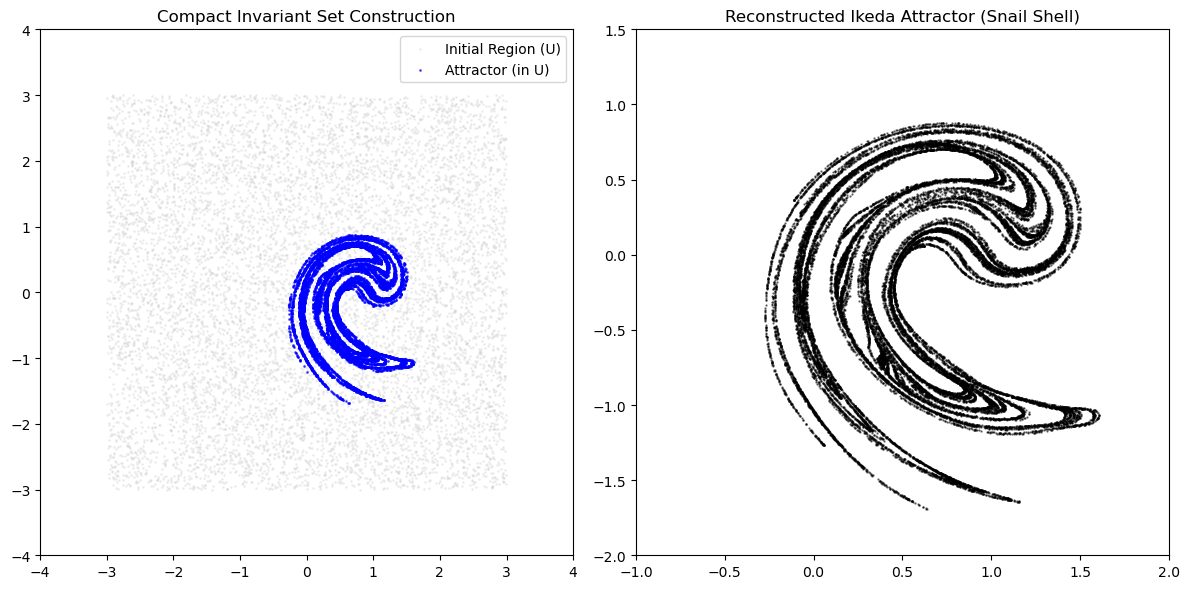

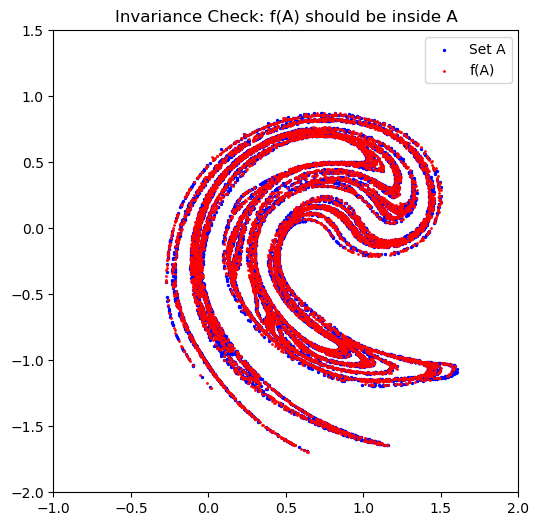

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Target: Ikeda Map (Non-polynomial, Transcendental)
def ikeda_map(xy, u=0.9):
    x, y = xy[:, 0], xy[:, 1]
    # 거리에 따른 위상 변화 (Non-polynomial part)
    t = 0.4 - 6.0 / (1.0 + x**2 + y**2)
    
    # Rotation & Scaling
    x_next = 1.0 + u * (x * np.cos(t) - y * np.sin(t))
    y_next = u * (x * np.sin(t) + y * np.cos(t))
    
    return np.stack([x_next, y_next], axis=1).astype(np.float32)

def generate_ikeda_data(steps=10000):
    # Start usually implies a transient
    traj = [np.array([0.0, 0.0])]
    for _ in range(1000): # Remove transient (longer due to complex dynamics)
        traj[0] = ikeda_map(np.array([traj[0]]))[0]
        
    for _ in range(steps):
        traj.append(ikeda_map(np.array([traj[-1]]))[0])
    return np.vstack(traj).astype(np.float32)

# 2. Neural Network
# Tanh is particularly good here because the target involves Sin/Cos
class IkedaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128), # 좀 더 복잡하므로 뉴런 수 증가
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# 3. Train
data = generate_ikeda_data(steps=8000)
X_train = torch.from_numpy(data[:-1])
Y_train = torch.from_numpy(data[1:])

model = IkedaNet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

print("Training NN on Ikeda Map (Non-polynomial)...")
for epoch in range(1500):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()
    if epoch % 300 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# 4. Visualization: Empirical Invariant Set
# Ikeda Map의 Basin of Attraction은 꽤 넓습니다.
# 큰 사각형 영역에서 시작해서 어떻게 소라껍질 모양으로 말려 들어가는지 봅니다.

n_samples = 10000
# Initial Region: [-3, 3] x [-3, 3]
initial_state = (torch.rand(n_samples, 2) - 0.5) * 6.0 

states = [initial_state]
current_state = initial_state

with torch.no_grad():
    for _ in range(20): # 20 steps evolution
        current_state = model(current_state)
        states.append(current_state)

# Plotting
plt.figure(figsize=(12, 6))

# View 1: Initial vs Final (The concept of Trapping)
plt.subplot(1, 2, 1)
s0 = states[0].numpy()
s_final = states[-1].numpy()

plt.scatter(s0[:,0], s0[:,1], s=1, c='lightgray', alpha=0.3, label='Initial Region (U)')
plt.scatter(s_final[:,0], s_final[:,1], s=1, c='blue', alpha=0.6, label='Attractor (in U)')
plt.title("Compact Invariant Set Construction")
plt.legend()
plt.xlim(-4, 4); plt.ylim(-4, 4)

# View 2: Detailed Attractor Structure
plt.subplot(1, 2, 2)
# 마지막 몇 스텝을 겹쳐서 그립니다 (to see the density)
colors = ['red', 'orange', 'yellow']
for i in range(3):
    s = states[-(i+1)].numpy()
    plt.scatter(s[:,0], s[:,1], s=0.5, c='black', alpha=0.5)

plt.title("Reconstructed Ikeda Attractor (Snail Shell)")
plt.xlim(-1, 2); plt.ylim(-2, 1.5) # Zoom in

plt.tight_layout()
plt.show()

# Verification of "f(U) subset U"
# 최종적으로 수렴한 집합(Attractor)을 U_eff 라고 할 때,
# 이것을 한 번 더 매핑했을 때 밖으로 튀어나가지 않는지 확인
U_eff = states[-1]
with torch.no_grad():
    U_next = model(U_eff)

s_u = U_eff.numpy()
s_next = U_next.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(s_u[:,0], s_u[:,1], s=2, c='blue', label='Set A')
plt.scatter(s_next[:,0], s_next[:,1], s=1, c='red', label='f(A)')
plt.title("Invariance Check: f(A) should be inside A")
plt.legend()
plt.xlim(-1, 2); plt.ylim(-2, 1.5)
plt.show()

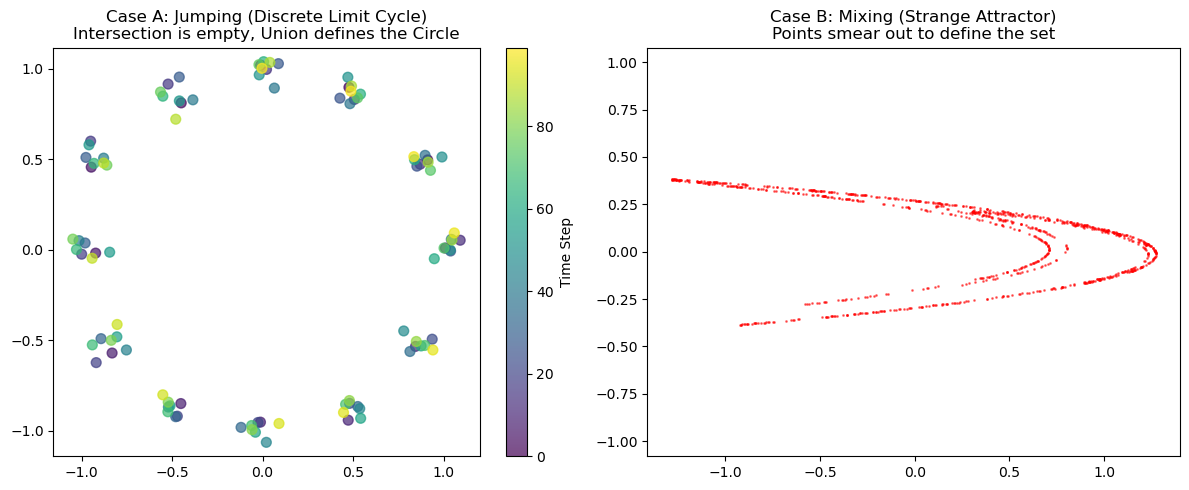

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dynamics_comparison():
    plt.figure(figsize=(12, 5))

    # Case 1: Jumping Dynamics (Discrete Clock)
    # 12개의 점을 순환
    angles = np.linspace(0, 2*np.pi, 13)[:-1]
    clock_points = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    
    # 궤적 생성 (점프)
    traj_clock = []
    for i in range(100):
        # i번째 점 + 약간의 노이즈 (분포의 이동 표현)
        idx = i % 12
        pt = clock_points[idx] + np.random.randn(2) * 0.05
        traj_clock.append(pt)
    traj_clock = np.array(traj_clock)

    plt.subplot(1, 2, 1)
    plt.scatter(traj_clock[:,0], traj_clock[:,1], c=np.arange(100), cmap='viridis', s=50, alpha=0.7)
    plt.title("Case A: Jumping (Discrete Limit Cycle)\nIntersection is empty, Union defines the Circle")
    plt.colorbar(label='Time Step')
    plt.axis('equal')

    # Case 2: Mixing Dynamics (Hénon)
    # 궤적이 공간을 펴 바름
    def henon(xy):
        x, y = xy[0], xy[1]
        return np.array([1 - 1.4*x**2 + y, 0.3*x])
    
    traj_henon = [np.array([0.0, 0.0])]
    for _ in range(100): # Burn-in
        traj_henon[0] = henon(traj_henon[0])
        
    for _ in range(1000):
        traj_henon.append(henon(traj_henon[-1]))
    traj_henon = np.array(traj_henon)

    plt.subplot(1, 2, 2)
    plt.scatter(traj_henon[:,0], traj_henon[:,1], c='red', s=1, alpha=0.5)
    plt.title("Case B: Mixing (Strange Attractor)\nPoints smear out to define the set")
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

plot_dynamics_comparison()